# Brain Tumor Prediction

In this project, a deep learning model will be developed to classify brain tumor based on MRI scans. The deep learning model will use tensorflow/keras framework. A baseline model (Tensorflow model based on alexnet architecture) and a proposed model ()
odel (Functional Model) would be developed.

## Import Needed Libraries

In [20]:
!pip install optuna
!pip install pynvml

In [21]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import glob
from typing import Dict, Any
import pickle
import pynvml

# Data prepreocessing Libraries
from sklearn.model_selection import train_test_split
import cv2

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAvgPool2D, BatchNormalization, Conv2D, MaxPooling2D, Activation, Add
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Hyperparameter tuning Libraries
import optuna
## Suppress warnings from Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# For Cleaner Notebook
from tqdm import tqdm

## GPU check

In [22]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")

    # Initialize the pynvml library
    pynvml.nvmlInit()

    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()

    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: NVIDIA A100-SXM4-40GB


In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing the Dataset

First lets import the image while creating a dataframe that contains:
<table>
<tr>
<th>Column</th>
<th>Description</th>
</tr>
<tr>
<td>path_to_image</td>
<td>The path to the image</td>
</tr>
<tr>
<td>label</td>
<td>The label of the image</td>
</tr>
<tr>
<td>img_width</td>
<td>The width of the image</td>
</tr>
<tr>
<td>img_height</td>
<td>The height of the image</td>
</tr>
<tr>
<td>channel_info</td>
<td>The color channel of the image (e.g. grayscale or RGB)</td>
</tr>
</table>

Creating this dataframe allows for easier inspection of the dataset’s structure. It helps us detect any inconsistencies, such as varying image sizes or unexpected channel formats. Additionally, this format simplifies visualizations and statistical summaries, making EDA more efficient and insightful.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
def img_to_df(img_path: str):
    """
    Convert image to DataFrame.

    Args:
        img_path (str): Path to the folder containing the image.

    Returns:
        pd.DataFrame: DataFrame containing image path, label, width, height, and channel_info.
    """
    #checks
    if not isinstance(img_path, str):
        raise TypeError("img_path must be a string.")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"The path {img_path} does not exist.")
    if not os.path.isdir(img_path):
        raise NotADirectoryError(f"The path {img_path} is not a directory.")

    # Get the list of all image files in the directory
    glob_path = os.path.join(img_path, "**", "*.jpg")
    print(f"glob_path: {glob_path}")

    image_path = glob.glob(glob_path, recursive=True) #recursive=True is to allow for subdirectories to be searched
    print(f"image_path: {image_path}")

    # Get the label from the directory name
    labels = []
    for path in tqdm(image_path, desc="Extracting labels", unit="image"):
        labels.append(path.split("/")[-1])

    # Get the width, height, and channel information of the images
    width = []
    height = []
    channel_info = []

    for path in tqdm(image_path, desc="Processing images", unit="image"):
        img = cv2.imread(path)
        h, w, c = img.shape

        #append to the list
        height.append(h)
        width.append(w)
        channel_info.append(c)

    #combine into one dataframe
    df = pd.DataFrame({
        "image_path": image_path,
        "label": labels,
        "width": width,
        "height": height,
        "channel_info": channel_info
    })
    return df

In [26]:
img_df = img_to_df("/content/drive/MyDrive/Brain_tumor_project/Data_02")

glob_path: /content/drive/MyDrive/Brain_tumor_project/Data_02/**/*.jpg
image_path: ['/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0014.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0013.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0012.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0011.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0015.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0010.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0023.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0019.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0024.jpg', '/content/drive/MyDrive/Brain_tumor_project/Data_02/Testing/pituitary/Te-pi_0028.jpg', '/content/drive/MyDrive/Brain_tumor_project/Da

Processing images: 100%|██████████| 7023/7023 [00:29<00:00, 235.36image/s]


## EDA

### Functions for plotting distribution

In [27]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [28]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [29]:

#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories

        #Create the bar plot
        axes[i].bar(counts.index, counts)

        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")

        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt


### Split data to categorical and numerical

In [30]:
categorical_data = img_df.select_dtypes(exclude=[np.number])
numerical_data = img_df.select_dtypes(include=[np.number])

### Plotting

#### Numerical data plot

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

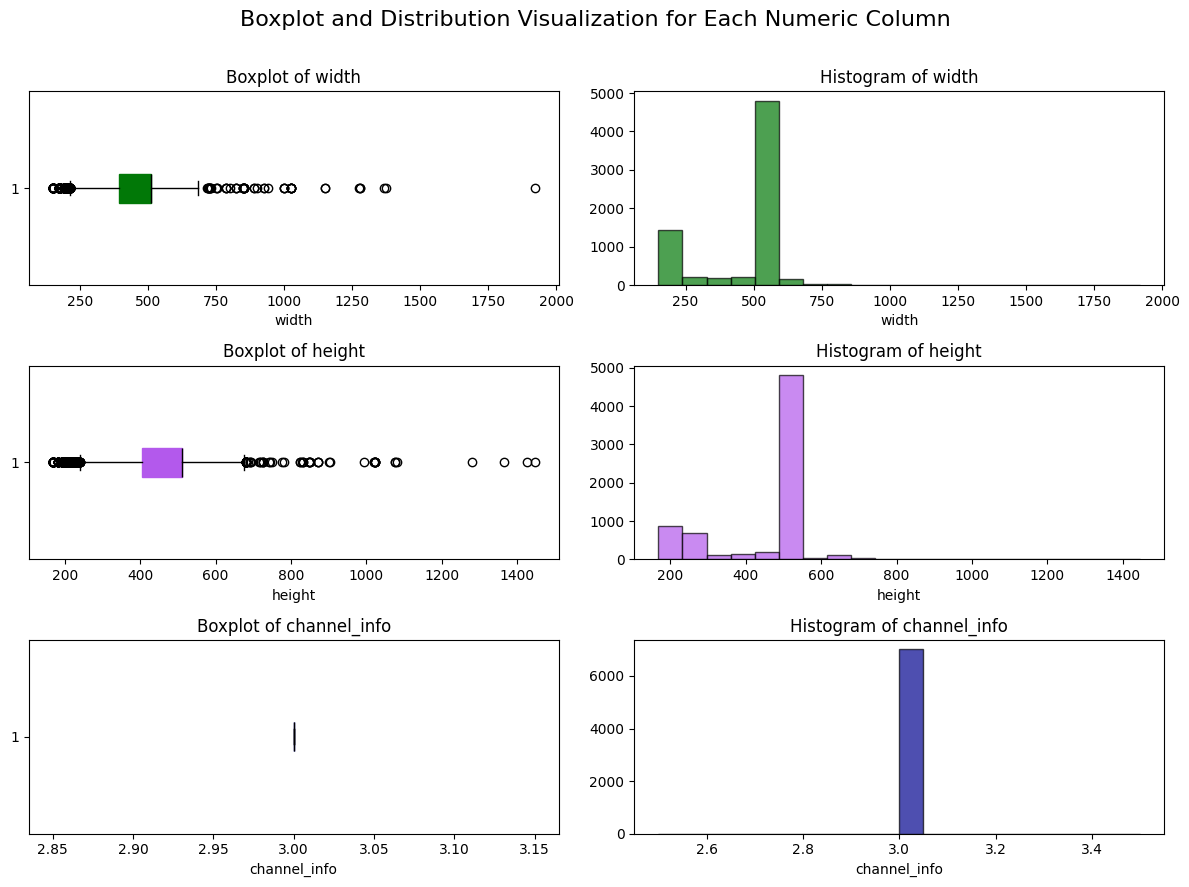

In [31]:
numeric_dist_plot(numerical_data)

Based on the distribution of the dataset, we observe that **most images have dimensions around 500 to 550 pixels** in both width and height. Therefore, resizing the images to 550 pixels is a suitable choice, as it follows the original size of the majority of the dataset. This minimizes the loss of detail during resizing, ensuring the model retains important features for learning, especially compared to resizing to significantly larger or smaller dimensions.

#### Categorical data plot

In [32]:
categorical_data.head()

,image_path,label
0,/content/drive/MyDrive/Brain_tumor_project/Dat...,Te-pi_0014.jpg
1,/content/drive/MyDrive/Brain_tumor_project/Dat...,Te-pi_0013.jpg
2,/content/drive/MyDrive/Brain_tumor_project/Dat...,Te-pi_0012.jpg
3,/content/drive/MyDrive/Brain_tumor_project/Dat...,Te-pi_0011.jpg
4,/content/drive/MyDrive/Brain_tumor_project/Dat...,Te-pi_0015.jpg


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

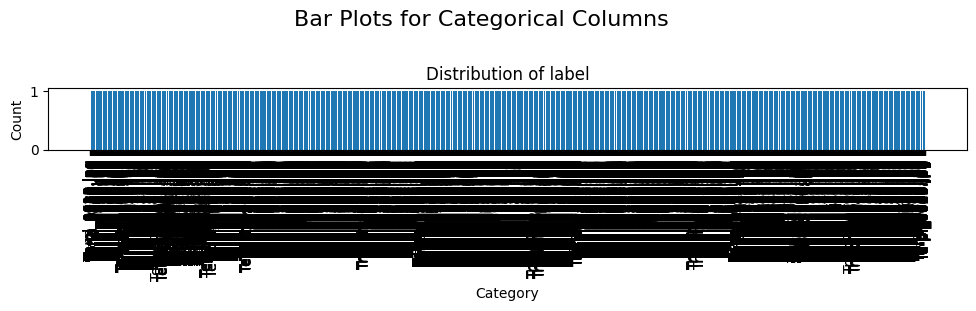

In [33]:
#no need to plot image path since it does not give any value to the analysis
categoric_dist_plot(categorical_data[["label"]])

The distribution of the labels appears to be relatively balanced across the different classes, with no significant skew. This is ideal for training a classification model, as it reduces the risk of bias toward any particular class and helps the model learn to generalize better across all categories.

**Next Steps**
- Resize the image to 550 by 550 when importing
- Make image to grayscale
- split data to train, validation, and test. (since there is only train and test)

## Preprocessing the data

#### Load the dataset

In [44]:
# the desired image size for the model
# even though the best size to use in this case is 550x550, we will use 224x224 since we will be using AlexNet architecture where the input size is 224x224
img_width = 224
img_height = 224

#image preprocessing and loading function
def preprocess_image(image_path: str, img_width: int, img_height: int):
    """
    Preprocess the image for model input.

    Args:
        image_path (str): Path to the image.

    Returns:
        np.ndarray: Preprocessed image.
    """
    # Read the image
    img = cv2.imread(image_path)

    # Resize the image to the target size
    img = cv2.resize(img, (img_width, img_height))

    # Normalize pixel values to [0, 1]
    img = (img.astype("float32") / 255.0).astype("float32")

    return img

#function to create train, validation and test datasets
def create_datasets(df: pd.DataFrame, img_width: int, img_height: int, test_size: float = 0.2, val_size: float = 0.15) -> Dict:
    """
    Create train, validation, and test datasets.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        img_width (int): Width of the images.
        img_height (int): Height of the images.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        Dict: Dictionary containing train, validation, and test datasets.
    """
    # Splitting the data into train and temp (which will be further split into validation and test)
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42) #stratify is used to ensure that the same proportion of each class is present in both the training and test sets

    # Splitting train into validation and test sets
    train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df['label'], random_state=42)

    # Preprocess images
    ## Train Images
    train_images = []
    for img_path in tqdm(train_df['image_path'], desc="Processing Train Images"): #tqdm is used to show the progress bar
        img = preprocess_image(img_path, img_width, img_height)
        train_images.append(img)

    train_images = np.array(train_images)

    ## validation images
    val_images = []
    for img_path in tqdm(val_df['image_path'], desc="Processing Validation Images"):
        img = preprocess_image(img_path, img_width, img_height)
        val_images.append(img)

    val_images = np.array(val_images)

    ## test images
    test_images = []
    for img_path in tqdm(test_df['image_path'], desc="Processing Test Images"):
        img = preprocess_image(img_path, img_width, img_height)
        test_images.append(img)

    test_images = np.array(test_images)

    # Convert labels to categorical format
    train_labels = pd.get_dummies(train_df['label'], dtype=int) #make it into indicator variable (in other words, one-hot encoding)
    val_labels = pd.get_dummies(val_df['label'], dtype=int)
    test_labels = pd.get_dummies(test_df['label'], dtype=int)

    return {
        'train_images': train_images,
        'train_labels': train_labels,
        'val_images': val_images,
        'val_labels': val_labels,
        'test_images': test_images,
        'test_labels': test_labels
    }

### Caching for faster image loading

In [45]:
def save_cache(data, filename):
    """This is a function to save the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to save the data to
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

def load_cache(filename):
    """This is a function to load the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)
    print(f"Data loaded from {filename}")

#### Caching Function

In [46]:
if os.path.exists("cached_dataset.pkl"):
    print("Loading cached dataset...")
    dataset = load_cache("cached_dataset.pkl")
else:
    print("Creating and caching dataset...")
    dataset = create_datasets(img_df, img_width, img_height, test_size=0.2, val_size=0.15) #15% of the training data will be used for validation and 20% of the data will be used for testing
    save_cache(dataset, "cached_dataset.pkl")

Creating and caching dataset...


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Model Making

### Baseline Model

The model will use AlexNet achitectire

In [39]:
def build_alexnet_sequential(img_height: int, img_width: int, num_classes: int):
    """Builds the AlexNet model using the Sequential API.

    Args:
        img_height (int): the height of the image
        img_width (int): the width of the image
        num_classes (int): the number of output classes

    Raises:
        TypeError: if any argument is not an integer
        ValueError: if any argument is not a positive integer

    Returns:
        model: a Sequential AlexNet model
    """
    # Checks
    if not isinstance(img_height, int) or not isinstance(img_width, int) or not isinstance(num_classes, int):
        raise TypeError("img_height, img_width and num_classes must be integers.")
    if img_height <= 0 or img_width <= 0 or num_classes <= 0:
        raise ValueError("img_height, img_width and num_classes must be positive integers.")

    model = Sequential()
    model.add(Input(shape=(img_height, img_width, 3)))
    # 1st Conv Layer
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 2nd Conv Layer
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 3rd Conv Layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # 4th Conv Layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # 5th Conv Layer
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))

    #output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    #early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      mode = 'max', #to match the fmin function from hyperopt
                                                                    #we will search for the model with the least loss
                                                      verbose=1,
                                                      patience=3)
    #compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


#### Train the AlexNet Model

In [40]:
model = build_alexnet_sequential(img_height, img_width, len(dataset['train_labels'].columns))

NameError: name 'dataset' is not defined

In [ ]:
tqdm(model.fit(dataset["train_images"], dataset["train_labels"], epochs=10, validation_data=(dataset["val_images"], dataset["val_labels"]), batch_size=32, verbose=1), desc = "Training the model") #batch size is set to 32 since it is the default value for most of the models and it is a good starting point for most of the models

#### Test the AlexNet Model

In [ ]:
AlexNet_pred = model.predict(dataset["test_images"], batch_size=32, verbose=1)
#convert the predictions to categorical values
AlexNet_pred = np.argmax(AlexNet_pred, axis=1)
#convert the test labels to categorical values
test_labels = np.argmax(dataset["test_labels"], axis=1)

#### Model Evaluation

##### Model Loss and Accuracy

In [ ]:
evaluated_AlexNet = model.evaluate(dataset["test_images"], dataset["test_labels"], verbose=1) #evaluate the model on the test set

In [ ]:
print(f"Test Loss: {evaluated_AlexNet[0]}")
print(f"Accuracy: {evaluated_AlexNet[1]}")

##### Confusion matrix

In [ ]:
alex_cm = confusion_matrix(test_labels, AlexNet_pred)
class_names = dataset["test_labels"].columns.tolist()
sns.heatmap(
    alex_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of AlexNet")

plt.show()

##### Classification report

In [41]:
print(classification_report(test_labels, AlexNet_pred))

NameError: name 'test_labels' is not defined

The model **failed to generalize** well across all classes, likely due to insufficient feature extraction or class imbalance, which caused the model to become **biased towards predicting a single class**.

The confusion matrix and classification report indicate that the model struggles with recognizing glioma, meningioma, and pituitary tumor classes, while it **performs relatively better only on the "no tumor" class**, essentially predicting it for most inputs.

The poor precision, recall, and F1-scores for the tumor classes further support the hypothesis that the **model is not distinguishing these classes effectively**, largely due to the model **defaulting** to predicting the "no tumor" class.

**Next steps**:
1. Apply data augmentation during training so that the machine can learn more
2.  

### Proposed Model
We will use resnet50 architechture since it is said that ResNet-50 architecture, a form of Convolutional Neural Network (CNN), has been successfully used to detect brain cancers in MRI scans. Studies have demonstrated that adding ResNet-50 into the classification model has resulted in outstanding accuracy rates, such as 92% accuracy and 94% precision. <a href="https://www.sciencedirect.com/science/article/pii/S3050475924001039#:~:text=ResNet-50%20architecture%2C%20a%20type,94%20%25%20precision%20%5B9%5D.">(Maquen-Niño, et al., 2023, as cited in rath et al., 2025)</a>

#### Data Augmentation
so that the machine can learn with more data

In [ ]:

# this uses the ImageDataGenerator to augment the images and make more images from the original images
datagen = ImageDataGenerator(
    rotation_range=30, #spins the image
    horizontal_flip=True, #flips the image horizontally
    vertical_flip=True, #flips the image vertically
    zoom_range=0.2, #zooms into the image
    width_shift_range=0.2, #shifts the image to the left or right
    height_shift_range=0.2, #shifts the image up or down
    shear_range=0.2, #skews the image
    brightness_range=[0.2, 1.0], #changes the brightness of the image
    channel_shift_range=0.2, #shifts the color channels of the image
    fill_mode='nearest' #fills the empty pixels with the nearest pixel value
)

datagen.fit(dataset["train_images"])

#### Resnet 50
we will use the resnet 50 architectire as shown below

<img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/ResNet50.png/1200px-ResNet50.png?20211021163926" style="background-color:white; width:40%;">
<br>
<img src= "https://miro.medium.com/v2/resize:fit:828/format:webp/1*rPktw9-nz-dy9CFcddMBdQ.jpeg" style="background-color:white; width:40%;">

and for code reference can be seen <a href="https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-resnet-from-scratch-with-tensorflow-2-and-keras.md">here</a>

Resnet 50 has two methods in one block:
- The regullar mapping (Adding more layers to the neural network)
- A skip connectopn (Skipping the connection to preserve details)

Using a functional model is more beneficial since we are dealing with residual connections and multiple paths, which is the essence of ResNet-like architectures as reccomended by <a href="https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-resnet-from-scratch-with-tensorflow-2-and-keras.md">lucasew</a>.

##### Custom metrics

In [ ]:
def recall_c(y_true, y_pred): #c for custom
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return keras.backend.cast(recall, "float16")

def precision_c(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return keras.backend.cast(precision, "float16")

def f1_score_c(y_true, y_pred):
    precision = precision_c(y_true, y_pred)
    recall = recall_c(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return keras.backend.cast(f1, "float16")

In [42]:

# stack the identity blocks and conv blocks to create the ResNet model
def build_resnet50(trial):  # or 2 for binary
    inputs = Input(shape=(224, 224, 3))

    # Stage 1
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Stage 2
    x = conv_block(x, [64, 64, 256], stride=1) # conv_block = for dimension change
    x = identity_block(x, [64, 64, 256]) # identity_block = for same shape
    x = identity_block(x, [64, 64, 256])

    # Stage 3
    x = conv_block(x, [128, 128, 512]) # conv_block = for dimension change
    x = identity_block(x, [128, 128, 512]) # identity_block = for same shape
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

        # Stage 4
    x = conv_block(x, [256, 256, 1024])
    for _ in range(5):
            x = identity_block(x, [256, 256, 1024])

    # Stage 5
    x = conv_block(x, [512, 512, 2048]) # conv_block = for dimension change
    x = identity_block(x, [512, 512, 2048]) # identity_block = for same shape
    x = identity_block(x, [512, 512, 2048])

    x = GlobalAveragePooling2D()(x) # Replacement of Flatten layer by computing the average of each feature map transforming from (H x W x C) to (1 x 1 x C) to a 1D vector
    x = Dense(512, activation='relu')(x)

    #Dropout rate
    dropout = trial.suggest_float("dropout", 0.1, 0.5) # Hyperparameter tuning for dropout rate
    x = Dropout(dropout)(x)

    #output layer
    outputs = Dense(4, activation='softmax')(x) #there are 4 categories in the dataset

    model = Model(inputs=inputs, outputs=outputs)

    #compile the model
    #learning rate
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True) # Hyperparameter tuning for learning rate

    #optimizer
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "rms"]) # Hyperparameter tuning for optimizer
    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        momentum = trial.suggest_float("momentum", 0.0, 0.9) # Hyperparameter tuning for momentum
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == "rms":
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score_c])

    early_stop = EarlyStopping(monitor='val_f1_score_c', patience=3, restore_best_weights=True) #Since we're predicting between 'no disease'(i.e. healthy brain) and 'disease'(i.e, the tumors), it's important to balance both false positives and false negatives.

    model_result = model.fit(datagen.flow(dataset["train_images"], dataset["train_labels"], batch_size=32, shuffle=True, seed=42), #this will shuffle the images and labels so that they are not in the same order as the original images and labels)
                            epochs=10, #number of epochs to train the model
                            validation_data=(dataset["val_images"], dataset["val_labels"]), #validation data to use for validation
                            batch_size=32, #batch size to use for training
                            verbose=1, #show the progress of the training
                            callbacks=[early_stop]) #early stopping to stop the training if the validation accuracy does not improve for 3 epochs`)
    return model


<h6 style="font-size:1.5rem">For cleaner output</h6>

In [43]:
n_trials = 10 # Number of trials for Optuna to seach for the best hyperparameters

# For a cleaner output
prog_bar = tqdm(total=n_trials, desc="Finding best hyperparameters", leave=True) #leave is for not removing the progress bar after completion

def tqdm_callback(study, trial):
    """This function is used to create a progress bar for the Optuna study.

    Args:
        study (_Optuna study object_): Optuna study object
        trial (_Optuna trial object_): Optuna trial object
    """
    prog_bar.set_postfix(best_value=study.best_value, trial=trial.number)
    prog_bar.update(1)

#start gridsearch
RNet50_study = optuna.create_study(direction="maximize") # Maximize the f1_score
RNet50_study.optimize(build_resnet50, n_trials=n_trials, show_progress_bar=True, callbacks=[tqdm_callback])

print("Number of finished trials: ", len(seq_study.trials))
print("Best seq_trial:")

seq_trial = seq_study.best_trial

print("\tValue: ", seq_trial.value)
print("\tParams: ")

for key, value in seq_trial.params.items():
    print(f"\t\t{key}: {value}")


Finding best hyperparameters:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Finding best hyperparameters:   0%|          | 0/10 [00:01<?, ?it/s]

[W 2025-04-16 08:56:17,138] Trial 0 failed with parameters: {} because of the following error: NameError("name 'conv_block' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-42-d770f7e91cc0>", line 12, in build_resnet50
    x = conv_block(x, [64, 64, 256], stride=1) # conv_block = for dimension change
        ^^^^^^^^^^
NameError: name 'conv_block' is not defined
[W 2025-04-16 08:56:17,141] Trial 0 failed with value None.


NameError: name 'conv_block' is not defined

### Gridsearch (Ongoing soon)

In [ ]:
def NAS_objective(trial):
    # Define the model architecture
    model = Sequential()

    # Hyperparameters to tune
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 5)  # Number of convolutional layers
    num_dense_layers = trial.suggest_int("num_dense_layers", 1, 3)  # Number of dense layers

    model.add(Input(shape=(224, 24, 3)))

    for i in range(num_conv_layers):
        # Hyperparameters to tune
        kernel_size = trial.suggest_int(f"conv_l{i}_kernel_size", 3, 7)  # Kernel size for convolutional layers
        filters = trial.suggest_int(f"conv_l{i}_filters", 32, 512)  # Number of filters for convolutional layers
        pooling = trial.suggest_categorical(f"l{i}_pooling", [True, False]) # Use pooling or no
        pooling_layer_type = trial.suggest_categorical(f"l{i}_pooling_type", ["max", "average"]) # Pooling layer type
        activation_func = trial.suggest_categorical(f"l{i}_activation", ["relu", "sigmoid", "tanh"]) # Activation function
            # Relu: computationally efficient and helps prevent the vanishing gradient problem.
            # Sigmoid: good for binary classification but can suffer from vanishing gradient problem.
            # Tanh: Can sometimes provide better training performance than sigmoid due to its range. but can also suffer from the vanishing gradient problem.
        padding = trial.suggest_categorical(f"l{i}_padding", ["same", "valid"]) # Padding type
        # Add convolutional layer
        model.add(layers.Conv2D(filters,
                                (kernel_size, kernel_size),
                                 padding=padding,
                                 activation= activation_func))
        # Add pooling layer
        if pooling:
            if pooling_layer_type == "max":
                model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            else:
                model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    # Dropout layer
    dropout = trial.suggest_categorical("dropout", [True, False]) # Use dropout or no
    if dropout:
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)  # Dropout rate
        model.add(layers.Dropout(dropout_rate))

    #flatten the output from the convolutional layers
    model.add(layers.Flatten())

    # Fully Connected Layers
    for i in range(num_dense_layers):
        # Hyperparameters to tune
        units = trial.suggest_int(f"dense_l{i}_units", 64, 512)  # Number of units for dense layers
        activation_func = trial.suggest_categorical(f"dense_l{i}_activation", ["relu", "sigmoid", "tanh"]) # Activation function

        model.add(layers.Dense(units, activation=activation_func))

    #output layer
    model.add(layers.Dense(4, activation='softmax')) #there are 4 categories in the dataset

    # Set optimizer
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # Learning rate
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])  # Optimizer
    if optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_f1_score_c', patience=3, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score_c]) #Since we're predicting between 'no disease'(i.e. healthy brain) and 'disease'(i.e, the tumors), it's important to balance both false positives and false negatives.

    # Fit the model
    train_results = model.fit(datagen.flow(dataset["train_images"], dataset["train_labels"], batch_size=32, shuffle=True, seed=42),
                            epochs=10, # Number of epochs
                            validation_data=(dataset["val_images"], dataset["val_labels"]),
                            batch_size=32, # Batch size
                            verbose=1, # show the progress of the training
                            callbacks=[early_stop] # Early stopping to stop the training if the validation accuracy does not improve for 3 epochs
                            )

    # get the score of the model
    val_accuracy = train_results.history['val_accuracy'][-1] # Get the last validation accuracy
    return val_accuracy

In [ ]:
n_trials = 10

#start gridsearch
NAS_study = optuna.create_study(direction="maximize") # Maximize the f1_score
NAS_study.optimize(build_resnet50, n_trials=n_trials, show_progress_bar=True, callbacks=[tqdm_callback])

print("Number of finished trials: ", len(NAS_study.trials))
print("Best seq_trial:")

seq_trial = NAS_study.best_trial

print("\tValue: ", seq_trial.value)
print("\tParams: ")

for key, value in seq_trial.params.items():
    print(f"\t\t{key}: {value}")